In [1]:
# prompt for extracting dates from user queries

from datetime import date
today = date.today().strftime("%Y-%m-%d")

# Optimierung:
# when did...? queries are sometimes directly answered by the model
# we need to ensure it only extracts dates, not answers them directly
# - DO NOT answer time based queries directly!
# - "When did XXX happen?" → no date contained in query itself, return nothing


system_prompt = f"""
You extract all dates or timeframes from user queries and return them in the format |YYYY-MM-DD|.

Rules:
- Use today as |{today}|.
- Convert relative terms (e.g. "yesterday", "last week", "next Friday") to exact dates.
- For months or years (e.g. "August", "2023"), assume the most recent past unless otherwise stated.
- For ranges (e.g. "May to July"), return one date per month (e.g. |YYYY-MM-01|, |YYYY-MM-31|).
- Return multiple dates if needed.
- Return nothing if no date is present.
- DO NOT answer time based queries directly!
- DO NOT return any text besides the date(s).

Examples:
- "How are you today?" → |{today}|
- "What did we do last week?" → date 7 days before |{today}|
- "Check August results" → most recent August before |{today}|
- "When did XXX happen?" → no date contained in query itself, return nothing
"""

cached_queries = {}

In [ ]:
# LLM call using the free DeepSeek model on OpenRouter

from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()

def ask_llm_for_help(query):
    #print("Asking LLM for help with query:", query)

    # Use cached responses to save on tokens for the paid API
    if cached_queries.get(query):
      #print("Using cached response for query:", cached_queries[query])
      return cached_queries[query]
    
    client = OpenAI(
      base_url="https://openrouter.ai/api/v1",
      api_key=os.getenv("OPENROUTER_API_KEY"),
    )

    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query}, 
    ]

    response = client.chat.completions.create(
      extra_headers={
        "HTTP-Referer": "<YOUR_SITE_URL>", # Optional. Site URL for rankings on openrouter.ai.
        "X-Title": "<YOUR_SITE_NAME>", # Optional. Site title for rankings on openrouter.ai.
      },
      extra_body={},
      model="deepseek/deepseek-r1-0528:free", #"deepseek/deepseek-r1-0528-qwen3-8b:free",
      messages= messages,
    )

    content = response.choices[0].message.content
    content = content if content else "no answer"
    cached_queries[query] = content
    #print("LLM response:", content)
    
    return content


In [2]:
# LLM call using OpenAI's GPT-4.1 model

from openai import OpenAI
import os
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

def ask_llm_for_help(query):
    #print("Asking LLM for help with query:", query)
    
    # Use cached responses to save on tokens for the paid API
    if cached_queries.get(query):
      #print("Using cached response for query:", cached_queries[query])
      return cached_queries[query]
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query}
    ]

    response = client.chat.completions.create(
        model="gpt-4.1",
        messages=messages
    )

    content = response.choices[0].message.content
    content = content if content else "no answer"
    cached_queries[query] = content
    #print("LLM response:", content)
    #print("tokens:", response.usage.total_tokens, "in/out:", response.usage.prompt_tokens, "/", response.usage.completion_tokens)

    return content


In [3]:
# Extract the timestamps from the LLM response

import re
from datetime import datetime

def extract_timestamps(query):
    response = ask_llm_for_help(query)
    # response = "|2016-08-05|" 
    # extract matches in the format |YYYY-MM-DD| from the response
    matches = re.findall(r"\|(\d{4}-\d{2}-\d{2})\|", response)
    timestamps = [datetime.strptime(date_str, "%Y-%m-%d").timestamp() for date_str in matches]
    return timestamps

def print_timestamps(timestamps):
    print("Extracted timestamps:")
    for ts in timestamps:
        print(datetime.fromtimestamp(ts).strftime("%Y-%m-%d"), ts)



In [4]:
# Example usage

#timestamps = extract_timestamps("Where were the Summer Olympics held in 2012?")
timestamps = extract_timestamps("When did Usain Bolt win his third straight Olympic 100-metre title?")
print_timestamps(timestamps) 

Extracted timestamps:


### TempRALM Retriever

In [5]:
# TempRALM Retriever Implementation

from datetime import datetime, timedelta
from typing import Any
import numpy as np
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_core.callbacks.manager import (
        AsyncCallbackManagerForRetrieverRun,
        CallbackManagerForRetrieverRun,
    )   
from langchain.docstore.document import Document

class TempRALMRetriever(VectorStoreRetriever):
    """
     Define a custom retriever based on the Paper by Anoushka Gade, Jorjeta Jetcheva
     https://arxiv.org/abs/2401.13222
     It's About Time: Incorporating Temporality in Retrieval Augmented Language Models
    """
    # alpha cancels out due to normalization, but is still used in the paper
    alpha: float = 1


    def __init__(self, *args, alpha: float = 0.1,  **kwargs):
        super().__init__(*args, **kwargs)

        
        object.__setattr__(self, "alpha", alpha) 
        object.__setattr__(self, "temporal_scores_all", []) 
        object.__setattr__(self, "semantic_scores_all", []) 

    # Overwrite _get_relevant_documents to use Custom Logic
    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun, **kwargs: Any
    ) -> list[Document]:
        
        docs = self._search_with_score(
            query,
            **kwargs,
        )
        return [doc for doc, _ in docs]

    # Custom search method
    def _search_with_score(
        self,
        query: str,
        **kwargs: Any,
    ) -> list[tuple[Document, float]]:
        
        _kwargs = self.search_kwargs | kwargs

        k = _kwargs.pop("k", 100)           # Default to 100 if not specified
        max_k = _kwargs.get("max_k", 100)   # Use max_k for over-retrieval

        if self.search_type == "similarity":
            search_kwargs = {k: v for k, v in kwargs.items() if k not in ['k', 'fetch_k']}

            # Important to retrieve max_k documents for over-retrieval and also get the cosine scores
            docs = self.vectorstore.similarity_search_with_score(
                query, k=max_k, filter=None, fetch_k=max_k, **search_kwargs)
        else:
            msg = f"search_type of {self.search_type} not allowed."
            raise ValueError(msg)
        
        # Sort documents by combined score (semantic + temporal)
        docs = self.sort_by_combined_score(docs, query, self.alpha, datetime.now().timestamp()) #self.vectorstore._client.current_time

        # Return only the top k documents
        return docs[:k]  


    def sort_by_combined_score(self, docs, query, alpha, current_time):

        # extract timestamps from the query using the LLM
        timestamps = extract_timestamps(query)

        if not timestamps: 
            # use current time if no timestamps are found
            timestamps = [datetime.now().timestamp()]

        # for TempRALM, we can only use a single timestamp
        # in case of multiple timestamps, we use the most recent one
        timestamps.sort(reverse=True)
        query_time = timestamps[0]

        # ensure it is the end of day, so the check qt >= dt does not mask out documents of the same day
        query_dt = datetime.fromtimestamp(timestamps[0]) + timedelta(hours=23, minutes=59, seconds=59) 
        query_time = query_dt.timestamp()



        # "Finally, to ensure a comprehensive coverage of relevant passages,
        # we over-retrieve of set of documents from the retriever, and from
        # this over-retrieved set, the 𝑡𝑜𝑝𝑘 documents with highest Temprett
        # scores are passed as input to the language model." (Gade and Jetcheva)
        # ->    amount of passages to over-retrieve is not defined in the paper
        #       hence we use a value of 100 for our dataset, see max_k in search_kwargs

        # get all temporal and semantic scores for normalization
        temporal_scores_all, semantic_scores_all = self._get_all_scores(docs, query_time, current_time)
        object.__setattr__(self, "temporal_scores_all", temporal_scores_all) 
        object.__setattr__(self, "semantic_scores_all", semantic_scores_all) 

        # compute combined scores and overwrite the original score
        # lots of performance improvements could be made here
        scored_docs = [
            (doc[0], self._get_combined_score(doc, doc[1], query_time, current_time))
            for doc in docs
        ]
        # actually sort by the combined score
        # reverse = True for cosine similarity, reversed = False for euclidean distance
        sorted_docs = sorted(scored_docs, key=lambda doc: doc[1], reverse=True)

        return sorted_docs
    
    def _get_all_scores(self, docs, query_time, current_time):
        # get all scores for normalization
        query_dt = datetime.fromtimestamp(query_time)

        temporal_scores_all = []
        semantic_scores_all = []
        for doc in docs:
            published_str = doc[0].metadata.get("Date published", current_time)
            published_dt = datetime.strptime(published_str, "%Y-%m-%d %H:%M:%S") 
            delta = (query_dt - published_dt).total_seconds() / (3600 * 24)
            if delta > 0:
                temporal_scores_all.append(self.alpha / delta)
                semantic_scores_all.append(doc[1])  # or distance

        return temporal_scores_all, semantic_scores_all


    def _get_combined_score(self, doc, distance: float, query_time, current_time):
        """
        Apply TempRALM combined score logic.
        temporal_scores_all: list of raw τ(qt, dt) for normalization
        semantic_scores_all: list of semantic scores (e.g., dot product or distance)
        """

        # Extract timestamps
        published_str = doc[0].metadata.get("Date published", current_time)
        published_dt = datetime.strptime(published_str, "%Y-%m-%d %H:%M:%S")
        query_dt = datetime.fromtimestamp(query_time)

        # Step 1: Raw temporal score = α / (qt - dt)
        delta_days = (query_dt - published_dt).total_seconds() / (3600 * 24)
        raw_temporal_score = self.alpha / delta_days

        # Step 2: Normalize temporal score
        mu_tau = np.mean(self.temporal_scores_all)
        sigma_tau = np.std(self.temporal_scores_all)
        mu_sem = np.mean(self.semantic_scores_all)
        sigma_sem = np.std(self.semantic_scores_all)

        normalized_temporal_score = ((raw_temporal_score - mu_tau) / sigma_tau) * sigma_sem + mu_sem

        # Step 3: Final score: semantic + normalized temporal
        # filter out documents where the published date is in the future compared to the query time
        if query_dt >= published_dt:
            combined_score = distance + normalized_temporal_score
        else:
            combined_score = float('-inf')

        # Save additional scores for iterpretation in the document metadata
        doc[0].metadata["combined_score"] = combined_score
        doc[0].metadata["default_score"] = distance
        doc[0].metadata["temporal_score"] = normalized_temporal_score
        return combined_score


### Experimental Retriever

In [6]:
# define a custom retriever that combines vector similarity with recency based on timestamps
# depending on the vector store implementation, cosine similarity or euclidean distance may be used.
# experimental implementation, to demonstrate a different approach 

from datetime import datetime
from typing import Any
import numpy as np
from langchain_core.vectorstores import VectorStoreRetriever
from langchain_core.callbacks.manager import (
        AsyncCallbackManagerForRetrieverRun,
        CallbackManagerForRetrieverRun,
    )   
from langchain.docstore.document import Document
 
class SemanticRecencyRetriever(VectorStoreRetriever):
    """
     uses exponential decay to determine the temporal score of a document
    """

    def __init__(self, *args, decay_rate: float = 0.01, alpha: float = 0.8,  **kwargs):
        super().__init__(*args, **kwargs)
        object.__setattr__(self, "alpha", alpha)            # weighting for semantic similarity
        object.__setattr__(self, "decay_rate", decay_rate)  # exponential decay rate for recency scoring


    def _get_relevant_documents(
        self, query: str, *, run_manager: CallbackManagerForRetrieverRun, **kwargs: Any
    ) -> list[Document]:
        
        docs = self._search_with_score(
            query,
            **kwargs,
        )
        return [doc for doc, _ in docs]
    
    def _search_with_score(
        self,
        query: str,
        **kwargs: Any,
    ) -> list[tuple[Document, float]]:
        
        _kwargs = self.search_kwargs | kwargs

        k = _kwargs.get("k", 100)           # Default to 100 if not specified
        max_k = _kwargs.get("max_k", 100)   # Use max_k for over-retrieval
    
        if self.search_type == "similarity":
            search_kwargs = {k: v for k, v in kwargs.items() if k not in ['k', 'fetch_k']}

            docs = self.vectorstore.similarity_search_with_score(
                query, k=max_k, filter=None, fetch_k=max_k, **search_kwargs)
        else:
            msg = f"search_type of {self.search_type} not allowed."
            raise ValueError(msg)
        
        # Lots of potential improvements like: filter out cosine < 0.5 to ensure semantic relevance
        # docs = [doc for doc in docs if doc[1] > 0.5]

        docs = self.sort_by_combined_score(docs, query, self.alpha, datetime.now().timestamp()) #self.vectorstore._client.current_time

        return docs[:k] # Return only the top k documents


    def sort_by_combined_score(self, docs, query, alpha, current_time):

        timestamps = extract_timestamps(query)

        if not timestamps: 
            # use current time if no timestamps are found
            timestamps = [datetime.now().timestamp()]

        # Improvements like support for multiple timestamps and then combine the results of both
        # Example for Query Decomposition, though we only use the first timestamp for now
        ts = timestamps[0]
        
        # compute combined scores and overwrite the original score
        scored_docs = [
            (doc[0], self._get_combined_score(doc, doc[1], ts, current_time))
            for doc in docs
        ]
        # actually sort by the combined score
        # reverse = True for cosine similarity, reversed = False for euclidean distance
        sorted_docs = sorted(scored_docs, key=lambda doc: doc[1], reverse=True)

        return sorted_docs
    

    # 2) eigenes Scoring: alpha*Semantik + (1-alpha)*Recency
    def _get_combined_score(self, doc, distance: float, query_time, current_time):

        published_str = doc[0].metadata.get("Date published", current_time)
        published_dt = datetime.strptime(published_str, "%Y-%m-%d %H:%M:%S")
        query_dt = datetime.fromtimestamp(query_time)

        # calculate the recency penalty based on the difference in days of the query and the published date
        days     = abs((query_dt - published_dt).total_seconds() / ( 3600 * 24 ))
        temporal_score   =  np.exp(-self.decay_rate * days)    # exp. Abklingfunktion e^(-λ * t)
        combined_score = self.alpha * distance + (1 - self.alpha) * temporal_score

        #alternative idee:  combined_score = distance * recency_penalty 
        #                   da recency penalty eine wahrscheinlichkeit ist
        #                   -> schlechte ergebnisse, da recency zu stark gewichtet wird
        
        # Save to metadata
        doc[0].metadata["combined_score"] = combined_score
        doc[0].metadata["default_score"] = distance
        doc[0].metadata["temporal_score"] = temporal_score
        return combined_score
        # lower scores are better for euclidean distance, higher scores are better for cosine similarity        


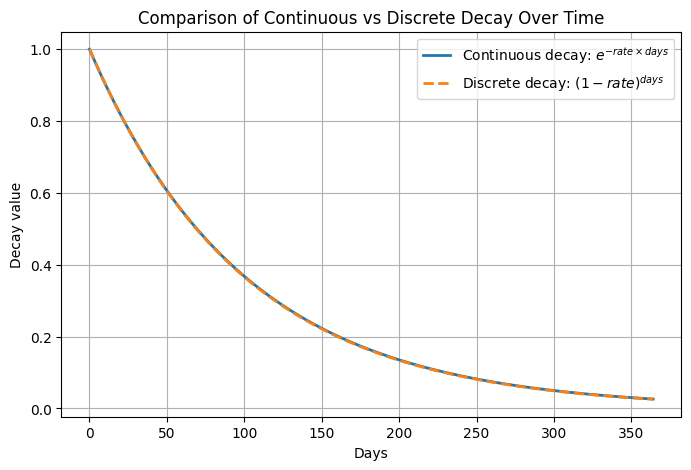

In [7]:
# Visualization of the formula for the relevance of a document based on recency
import numpy as np
import matplotlib.pyplot as plt

# Parameters
decay_rate = 0.01
days = np.arange(0, 365)

# Continuous decay
continuous_decay = np.exp(-decay_rate * days)

# Discrete decay
discrete_decay = (1 - decay_rate) ** days
#discrete_decay = 1/(days-1) - (1/days) 

# Plotting
plt.figure(figsize=(8,5))
plt.plot(days, continuous_decay, label='Continuous decay: $e^{-rate \\times days}$', linewidth=2)
plt.plot(days, discrete_decay, label='Discrete decay: $(1 - rate)^{days}$', linewidth=2, linestyle='--')
plt.title('Comparison of Continuous vs Discrete Decay Over Time')
plt.xlabel('Days')
plt.ylabel('Decay value')
plt.legend()
plt.grid(True)
plt.show()




### Load the dataset and index it in the VectorStore FAISS

In [ ]:
# Load and convert the Data

from langchain.docstore.document import Document
import pandas as pd
import sentence_transformers

file_path = "CNN_Articles.csv"

df = pd.read_csv(file_path)


def row_to_document(row):
    # Function to convert dataframe row to Langchain Document
    id = row["Index"]
    page_content = row['Description'] # instead of 'Article text'
    if pd.isna(page_content):
      print("no article text", row["Index"], row["Description"])
    metadata = {
        'Index': row['Index'],
        'Date published': row['Date published'],
    }
    return Document(id=id, page_content=page_content, metadata=metadata)

# Convert the dataframe to a list of Langchain Document objects
df_documents = df.apply(row_to_document, axis=1).tolist()
docs = df_documents
print("Number of documents:", len(docs))


# Initialize the embeddings model

from langchain.embeddings import HuggingFaceEmbeddings

# Tested embedding models:
# model_path = "sentence-transformers/all-MiniLM-l6-v2"
# model_path = "BAAI/bge-large-en-v1.5"
# model_path = "sentence-transformers/msmarco-distilbert-base-v3"
# model_path = "Qwen/Qwen3-Embedding-8B" model too big
# model_path = "Qwen/Qwen3-Embedding-4B" #arXiv:2506.05176 # model too big
# model_path = "Qwen/Qwen3-Embedding-0.6B" # best results for semantic only
# tempralm uses atlas, atlas uses contriever  https://arxiv.org/abs/2208.03299
model_path = "facebook/contriever"  # great results for the recency retriever, but worse in general

# model configuration options
model_kwargs = {'device':'cuda'}

# encoding options, 'normalize_embeddings' to True for Cosine similarity
encode_kwargs = {'normalize_embeddings': True}

# Initialize an instance of HuggingFaceEmbeddings with the specified parameters
embeddings = HuggingFaceEmbeddings(
    model_name=model_path,     # Provide the pre-trained model's path
    model_kwargs=model_kwargs, # Pass the model configuration options
    encode_kwargs=encode_kwargs # Pass the encoding options
)


# Either use FAISS or InMemoryVectorStore for the vector store
# FAISS uses euclidean distance by default
# InMemoryVectorStore uses cosine similarity

from langchain_community.vectorstores.utils import (
    DistanceStrategy,
    maximal_marginal_relevance,
)
from langchain.vectorstores import FAISS

# Cosine similarity (using MAX_INNER_PRODUCT on normalized vectors)
faiss_cosine = FAISS.from_documents(docs, embeddings, 
    normalize_L2=False, # normalization is done by the embeddings model, not FAISS
    distance_strategy=DistanceStrategy.MAX_INNER_PRODUCT)  

# Set the main db variable for compatibility with rest of code
db = faiss_cosine 


### Initialize the Retrievers

In [9]:
# initialize the retrievers to be evaluated

retrievers = {}  # retriever, score_function tuple
k = 10
max_k = 250 # max documents to over-retrieve, determined by optimizing for it

# 1) BM25 Retriever
from langchain_community.retrievers import BM25Retriever
bm25_retriever = BM25Retriever.from_documents(docs, k=k)
retrievers["BM25"] = ( bm25_retriever, None ) # BM25Retriever does not support score retrieval by default


# 2) Semantic Retriever using FAISS with MAX_INNER_PRODUCT (cosine)
faiss_cosine_retriever = faiss_cosine.as_retriever(search_type="similarity", search_kwargs={"k": k})
retrievers["Contriever"] = (faiss_cosine_retriever, faiss_cosine.similarity_search_with_score)

# 3) Semantic Recency Retriever with RALM
tempralm_retriever = TempRALMRetriever(
     vectorstore   = db,
     alpha = 1, # irrelevant
     search_kwargs = {"k": k, "max_k": max_k},
)
retrievers["TempRALM"] = (tempralm_retriever, tempralm_retriever._search_with_score)

# 4) Semantic Recency Retriever
semantic_recency_retriever = SemanticRecencyRetriever(    
    vectorstore   = db,
    decay_rate    = 0.01,      # wie schnell News „altern“ 
    alpha         = 0.9,       # 90 % Semantik, 10 % Temporal 
    search_kwargs = {"k": k, "max_k": max_k},
)
retrievers["Experimental"] = (semantic_recency_retriever, semantic_recency_retriever._search_with_score)


In [10]:
def get_document_by_id(retriever, doc_id):
    # Support for retriever that does not have a vectorstore (BM25)
    doc = None
    if not hasattr(retriever, "vectorstore"):
        doc = next((d for d in df_documents if str(d.id) == str(doc_id)), None) ## global docs
    else:
        vectorstore = retriever.vectorstore
        
        if hasattr(vectorstore, "docstore"):
            docstore = vectorstore.docstore
            # InMemoryDocstore is not subscriptable, use .search or ._dict
            if hasattr(docstore, "_dict"):
                # Try int and str keys
                doc = docstore._dict.get(doc_id) or docstore._dict.get(str(doc_id))
            else:
                try:
                    doc = docstore[doc_id]
                except KeyError:
                    try:
                        doc = docstore[str(doc_id)]
                    except KeyError:
                        doc = None

    # For InMemoryVectorStore (has .documents or ._documents)
        elif hasattr(vectorstore, "get_by_ids"):
            docs = vectorstore.get_by_ids([doc_id])
            doc = docs[0] if docs else None
    if doc is None:
        print(f"Document with ID {doc_id} not found in the vector store.")
        return None
    else:
        return doc

### Load and combine qrels and queries into a single file

In [11]:
# combine qrels from multiple topics into a single dictionary
# each topic is its own folder with a qrels.csv and a queries.csv file

from typing import Dict, Any
import csv

topics_folder = "topics"  # Folder containing topic subfolders with qrels and queries

def get_topic_folders(topics_folder):
    import os
    topic_folders = []
    for folder in os.listdir(topics_folder):
        folder_path = os.path.join(topics_folder, folder)
        if os.path.isdir(folder_path):
            topic_folders.append(folder_path)
    return topic_folders

def load_queries(queries_csv):
    queries = {}
    with open(queries_csv, newline='') as f:
        reader = csv.DictReader(f)
        for row in list(reader):
            queries[row['query_id']] = row['query']
    return queries

def load_qrels(qrels_csv):
    qrels = {}
    with open(qrels_csv, newline='') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            qid, _, doc_id, relevance = row
            qrels.setdefault(qid, {})[doc_id] = int(relevance)
    return qrels


# combine qrels and queries from multiple topics into a single dictionary
# the qid has to be unique across topics, so we prefix it with the folder name

def combine_topics(topic_folders: list[str]) -> Dict[str, Any]:
    all_queries = {}
    all_qrels = {}
    for folder in topic_folders:
        print(f"Processing topic folder: {folder}")
        queries_csv = f"{folder}/queries.csv"
        qrels_csv = f"{folder}/qrels.csv"

        # Load queries and qrels for the current topic
        queries = load_queries(queries_csv)
        qrels = load_qrels(qrels_csv)

        # qrels ids start at 1 for each topic, so we need to adjust them
        
        for qid, query in queries.items():
            # Adjust qid to be unique across topics
            unique_qid = f"{folder}_{qid}"
            all_queries[unique_qid] = query

        for qid, docs in qrels.items():
            unique_qid = f"{folder}_{qid}"
            for doc_id, relevance in docs.items():
                # Ensure the qid is unique across topics
                all_qrels.setdefault(unique_qid, {})[doc_id] = relevance
        
    return all_queries, all_qrels

def save_combined_topics(all_queries: Dict[str, str], all_qrels: Dict[str, Dict[str, int]]):
    import os

    # Save combined queries
    queries_csv = "combined_queries.csv"
    with open(queries_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['query_id', 'query'])
        for qid, query in all_queries.items():
            writer.writerow([qid, query])

    # Save combined qrels
    qrels_csv = "combined_qrels.csv"
    with open(qrels_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        for qid, docs in all_qrels.items():
            for doc_id, relevance in docs.items():
                writer.writerow([qid, '0', doc_id, relevance]) 

topics = get_topic_folders(topics_folder)
all_queries, all_qrels = combine_topics(topics)
save_combined_topics(all_queries, all_qrels)

Processing topic folder: topics\hurricanes
Processing topic folder: topics\olympics
Processing topic folder: topics\presidents


### General Evaluation

In [12]:
# Evaluate the retriever using BEIR's evaluation framework
# based on manually defined queries, qrels and the retriever's results

from beir.retrieval.evaluation import EvaluateRetrieval
from typing import Dict, Any
import csv

print_length = 500  # how many characters of the document to print

def evaluate_langchain_retriever(retriever, queries_csv: str, qrels_csv: str, k_values=[1, 3, 5, 10], score_function=None, verbose=True ) -> Dict[str, Any]:
    """
    Evaluate LangChain retriever using standard IR metrics (CSV version).

    Parameters:
        retriever: LangChain retriever with .get_relevant_documents(query)
        queries_csv: Path to CSV with 'qid', 'query'
        qrels_file: CSV/TSV with 'qid', '0', 'doc_id', 'relevance'
        k_values: List of K values (e.g., [1, 3, 5, 10])
        score_function: Optional function to retrieve the actual scores for each document

    Returns:
        Dicts: ndcg, recall, precision, map
    """
    # Load queries from CSV
    queries = load_queries(queries_csv)
    qrels = load_qrels(qrels_csv)

    # Retrieve for each query
    results = {}
    contents = {}
    for qid, query in queries.items():

        if score_function: # Use the provided score function to retrieve documents with scores
            docs = score_function(query, k = k_values[-1])
        else: # Use the default retriever function to get documents
            docs = retriever.invoke(query, k = k_values[-1])
        
        result_for_q = {}
        content_for_q = {}
        for idx, doc in enumerate(docs):
            # check if the retriever returned a score or not
            if isinstance(doc, tuple):
                doc, score = doc
            else:
                # no score available, e.g. for BM25Retriever
                score = len(docs)-idx 

            doc_id = doc.metadata["Index"]

            if doc_id:
                result_for_q[str(doc_id)] = float(score)
                content_for_q[str(doc_id)] = { 
                    "page_content": doc.page_content[:print_length], 
                    "scores": {
                        "combined": doc.metadata.get("combined_score", None),
                        "default": doc.metadata.get("default_score", None),
                        "temporal": doc.metadata.get("temporal_score", None),
                    }
                }
                
        results[qid] = result_for_q
        contents[qid] = content_for_q

    # Print queries, qrels and results
    if verbose:
        for qid in queries:
            print(f"\nQuery ID: {qid}, Query: {queries[qid]}")
            qrels_for_q = qrels.get(qid, {})
            print("Qrels for query:")
            for doc_id, relevance in list(qrels_for_q.items())[:k_values[-1]]:
                qrel_doc = get_document_by_id(retriever, doc_id)
                if qrel_doc is not None:
                    print(f"  Doc ID: {doc_id}, Relevance: {relevance}  text: {qrel_doc.page_content[:print_length]}...")
                else:
                    print(f"  Doc ID: {doc_id}, Relevance: {relevance}  text: [Document not found]")
            print("Retrieved documents:")
            results_for_q = results.get(qid, {})
            content_for_q = contents.get(qid, {})
            
            for doc_id, score in list(results_for_q.items())[:k_values[-1]]:  # Show top 5 results"
                content = content_for_q[doc_id]
                scores = content.get("scores", {})
                if scores.get("combined") is not None:
                    print(f"  Doc ID: {doc_id}, Score: {score:.4f}, Combined: {scores['combined']:.4f} Default: {scores['default']:.4f}, Temporal: {scores['temporal']:.4f}  text: {content['page_content'][:print_length]}...")
                else:
                    print(f"  Doc ID: {doc_id}, Score: {score:.4f}  text: {content['page_content'][:print_length]}...")


    # Evaluate
    evaluator = EvaluateRetrieval(k_values=k_values)
    ndcg, _map, recall, precision = evaluator.evaluate(qrels, results, k_values=k_values)

    # Print summary
    for k in k_values:
        print(
            f"Top-{k}:  "
            f"nDCG={ndcg[f'NDCG@{k}']:.4f} | "
            f"Recall={recall[f'Recall@{k}']:.4f} | "
            f"Precision={precision[f'P@{k}']:.4f} | "
            f"MAP={_map[f'MAP@{k}']:.4f}"
        )
    return {"nDCG": ndcg, "Recall": recall, "Precision": precision, "MAP": _map}



### Evaluate the Retrievers based on Question Type

Getting results for BM25...
Getting results for Contriever...
Getting results for TempRALM...


C:\Users\rober\AppData\Local\Temp\ipykernel_9252\3130708031.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  normalized_temporal_score = ((raw_temporal_score - mu_tau) / sigma_tau) * sigma_sem + mu_sem
C:\Users\rober\AppData\Local\Temp\ipykernel_9252\3130708031.py:154: RuntimeWarning: invalid value encountered in scalar multiply
  normalized_temporal_score = ((raw_temporal_score - mu_tau) / sigma_tau) * sigma_sem + mu_sem
C:\Users\rober\AppData\Local\Temp\ipykernel_9252\3130708031.py:154: RuntimeWarning: invalid value encountered in scalar divide
  normalized_temporal_score = ((raw_temporal_score - mu_tau) / sigma_tau) * sigma_sem + mu_sem
c:\Users\rober\OneDrive\Desktop\Programmieren\torch_vscode\torch_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rober\OneDrive\Desktop\Programmieren\torch_vscode\torch_venv\Lib\site-packages\numpy\_core\_methods.py:145: Runti

Getting results for Experimental...
['topics\\hurricanes_1', 'topics\\hurricanes_2', 'topics\\hurricanes_3', 'topics\\hurricanes_4', 'topics\\hurricanes_5', 'topics\\hurricanes_6', 'topics\\hurricanes_7', 'topics\\hurricanes_8', 'topics\\hurricanes_9', 'topics\\hurricanes_10', 'topics\\hurricanes_11', 'topics\\hurricanes_12', 'topics\\olympics_1', 'topics\\olympics_2', 'topics\\olympics_3', 'topics\\olympics_4', 'topics\\olympics_5', 'topics\\olympics_6', 'topics\\olympics_7', 'topics\\olympics_8', 'topics\\olympics_9', 'topics\\olympics_10', 'topics\\olympics_11', 'topics\\olympics_12', 'topics\\presidents_1', 'topics\\presidents_2', 'topics\\presidents_3', 'topics\\presidents_4', 'topics\\presidents_5', 'topics\\presidents_6', 'topics\\presidents_7', 'topics\\presidents_8', 'topics\\presidents_9', 'topics\\presidents_10', 'topics\\presidents_11', 'topics\\presidents_12']
grouped ids {0: ['topics\\hurricanes_1', 'topics\\hurricanes_2', 'topics\\olympics_1', 'topics\\olympics_2', 'topi

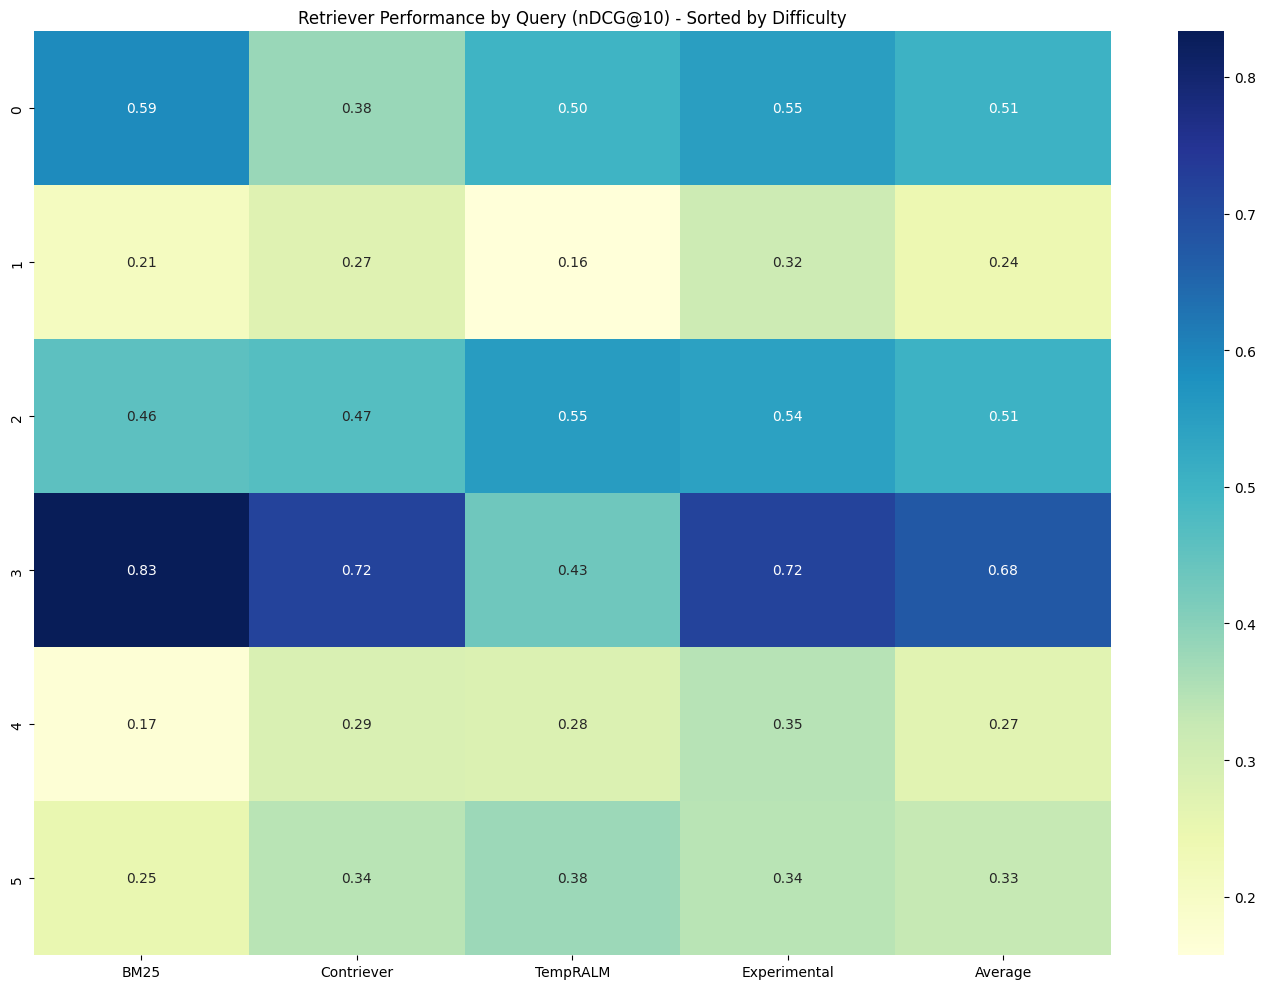

In [14]:
def compare_retrievers_on_groups(
    retrievers,
    queries_csv,
    qrels_csv,
    k_values=[1, 3, 5, 10],
):
    """
    Directly compare multiple retrievers on each individual query.
    
    Args:
        retrievers: Dict mapping retriever names to (retriever, score_function) tuples
        queries_csv: Path to CSV with queries
        qrels_csv: Path to CSV with relevance judgments
        k_values: List of k values to evaluate
        
    Returns:
        Detailed comparison of retrievers on each query
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    
    # Load queries and qrels
    queries = load_queries(queries_csv)
    qrels = load_qrels(qrels_csv)
    
    # Store results for each retriever on each query
    retriever_query_results = {}
    evaluator = EvaluateRetrieval(k_values=k_values)
    
    # For each retriever, get results for each query
    for retriever_name, (retriever, score_function) in retrievers.items():
        print(f"Getting results for {retriever_name}...")
        
        # Store query results for this retriever
        query_results = {}
        all_retrieved_docs = {}
        
        for qid, query in queries.items():
            
            # Get retrieved documents
            if score_function:
                docs = score_function(query, k=k_values[-1])
            else:
                docs = retriever.invoke(query, k=k_values[-1])
            
            # Convert to format required by evaluator
            result_for_query = {}
            retrieved_docs_for_query = {}
            
            for idx, doc in enumerate(docs):
                if isinstance(doc, tuple):
                    doc, score = doc
                else:
                    score = len(docs) - idx
                
                doc_id = str(doc.metadata["Index"])
                
                if doc_id:
                    result_for_query[doc_id] = float(score)
                    retrieved_docs_for_query[doc_id] = {
                        "content": doc.page_content[:200],  # Truncate for display
                        "position": idx + 1,
                        "relevance": qrels.get(qid, {}).get(doc_id, 0)  # 0 if not relevant
                    }
            
            # Store results for this query
            query_results[qid] = result_for_query
            all_retrieved_docs[(retriever_name, qid)] = retrieved_docs_for_query
        
        # Evaluate retriever on all queries
        ndcg, _map, recall, precision = evaluator.evaluate(qrels, query_results, k_values=k_values)
        
        # Get per-query metrics
        all_metrics = {}
        for qid in queries:
            # Create qrels and results dictionaries for just this query
            query_qrels = {qid: qrels.get(qid, {})}
            query_result = {qid: query_results.get(qid, {})}
            
            # Evaluate just this query
            try:
                q_ndcg, q_map, q_recall, q_precision = evaluator.evaluate(
                    query_qrels, query_result, k_values=k_values
                )
                
                all_metrics[qid] = {
                    'nDCG': q_ndcg,
                    'MAP': q_map,
                    'Recall': q_recall,
                    'Precision': q_precision
                }
            except Exception as e:
                print(f"    Error evaluating query {qid}: {e}")
                all_metrics[qid] = None
        
        # Store all results for this retriever
        retriever_query_results[retriever_name] = {
            'overall': {
                'nDCG': ndcg,
                'MAP': _map,
                'Recall': recall,
                'Precision': precision
            },
            'per_query': all_metrics,
            'retrieved_docs': all_retrieved_docs
        }
    

    # Create comparison visualizations
    top_k = k_values[-1]    # Use the largest k for visualization
    metric = 'nDCG'         # Primary metric
    
    
    # 2. Create a heatmap showing which retriever is best for each query
    # Reshape data for heatmap
    query_ids = list(queries.keys())
    retriever_names = list(retrievers.keys())
    
    # Calculate average score per query across all retrievers
    group_avg_scores = {}
    group_results = {}
    def idfn(pos, grp):
        return query_ids[( ( pos + grp * 2 ) - 1 ) % 36]
    grouped_query_ids = { }
    for i in range(0,6):
        grouped_query_ids[i] = [ idfn(1,i), idfn(2,i), idfn(13,i), idfn(14,i), idfn(25, i), idfn(26,i) ]

    print(query_ids)
    print("grouped ids", grouped_query_ids)
    for grp, qids in grouped_query_ids.items():
        
        group_results[grp] = {}
        for retriever_name in retriever_names:
            scores = []
            for qid in qids:
                try:
                    score = retriever_query_results[retriever_name]['per_query'][qid][metric][f'NDCG@{top_k}']
                    scores.append(score)
                except:
                    print("unable to get score for retriever", retriever_name, "for query", qid)
                    pass
            # Calculate average score for this retriever
            
            if scores:
                avg_score = sum(scores) / len(scores)
                group_results[grp][retriever_name] = avg_score
            else:
                print("no scores for group", grp, "retriever", retriever_name)
                group_results[grp][retriever_name] = 0
            print(scores)
            print("group", grp, retriever_name, sum(scores), len(scores), sum(scores) / len(scores))

        print("AVG GROUP", grp, sum(group_results[grp].values()), len(group_results[grp]))
        group_avg_scores[grp] = sum(group_results[grp].values()) / len(group_results[grp])
            



    # Create heatmap data matrix with extra column for average score
    heatmap_data = np.zeros((len(group_avg_scores), len(retriever_names) + 1))
    print(group_results)
    for grp, _ in enumerate(group_results):
        print(grp, group_results[grp])
        # Add individual retriever scores
        for j, retriever_name in enumerate(retriever_names):
            try:
                heatmap_data[grp, j] = group_results[grp][retriever_name]
            except:
                heatmap_data[grp, j] = 0
        
        # Add the average score in the last column
        heatmap_data[grp, -1] = group_avg_scores.get(grp, 0)
    
    # Create heatmap with combined score column
    plt.figure(figsize=(14, 10))
    
    # Create column labels with retrievers + "Average" for the last column
    col_labels = retriever_names + ["Average"]
    
    # Create row labels with query text and sorted by difficulty
    row_labels = [f"{grp}" for grp in group_results.keys()]
    
    # Create the heatmap
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        fmt=".2f", 
        cmap="YlGnBu",
        xticklabels=col_labels,
        yticklabels=row_labels
    )
    plt.title(f'Retriever Performance by Query ({metric}@{top_k}) - Sorted by Difficulty')
    plt.tight_layout()
    plt.show()
    
    return

kvals = [1, 3, 5, 10]
results = compare_retrievers_on_groups(
    retrievers=retrievers,
    queries_csv="combined_queries.csv", 
    qrels_csv="combined_qrels.csv",
    k_values=kvals,
)

### Visualize combined Results including ColBERTv2
has to be done manually by copying results from Google Colab

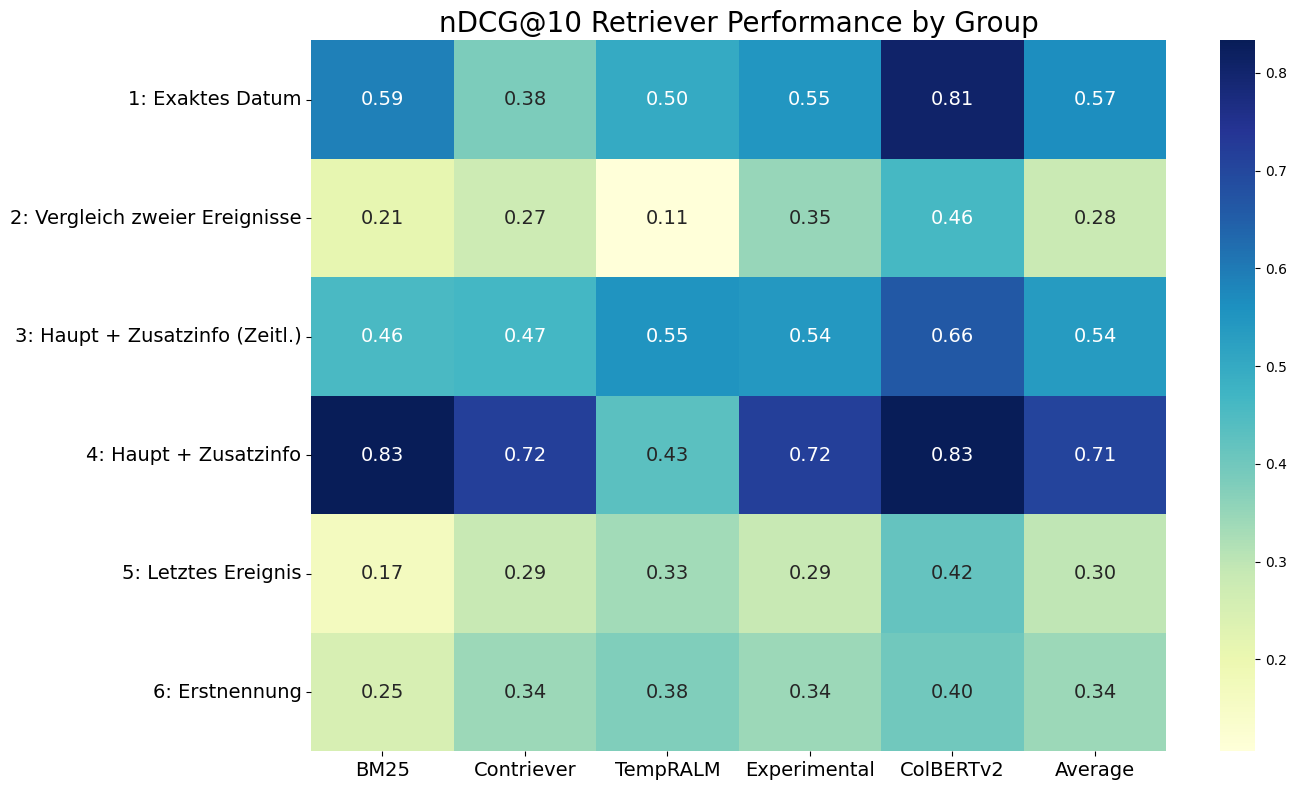

In [15]:

import seaborn as sns

retriever_names = ["BM25", "Contriever", "TempRALM", "Experimental", "ColBERTv2"]

group_results = {
    "1: Exaktes Datum": {'BM25': 0.5896183333333334, 'Contriever': 0.38165166666666667, 'TempRALM': 0.5, 'Experimental': 0.5487916666666667, 'ColBERTv2': 0.8065733333333333},
    "2: Vergleich zweier Ereignisse": {'BM25': 0.21122833333333335, 'Contriever': 0.27465666666666666, 'TempRALM': 0.10595166666666665, 'Experimental': 0.35005833333333336, 'ColBERTv2': 0.46264833333333333},
    "3: Haupt + Zusatzinfo (Zeitl.)": {'BM25': 0.4574583333333333, 'Contriever': 0.46647833333333333, 'TempRALM': 0.554655, 'Experimental': 0.5430816666666667, 'ColBERTv2': 0.6632283333333334},
    "4: Haupt + Zusatzinfo": {'BM25': 0.8333333333333334, 'Contriever': 0.7195883333333333, 'TempRALM': 0.432235, 'Experimental': 0.7195883333333333, 'ColBERTv2': 0.8333333333333334},
    "5: Letztes Ereignis": {'BM25': 0.16666666666666666, 'Contriever': 0.2866233333333333, 'TempRALM': 0.33389, 'Experimental': 0.2866233333333333, 'ColBERTv2': 0.4166666666666667},
    "6: Erstnennung": {'BM25': 0.25, 'Contriever': 0.34360166666666664, 'TempRALM': 0.3769766666666667, 'Experimental': 0.34360166666666664, 'ColBERTv2': 0.3987983333333333},
}

# Calculate average score per query across all retrievers
group_avg_scores = {}
for grp, results in group_results.items():
    group_avg_scores[grp] = sum(results.values()) / len(results)

# Create heatmap data matrix with extra column for average score
heatmap_data = np.zeros((len(group_avg_scores), len(retriever_names) + 1))
idx = 0
for grp, results in group_results.items():
    # Add individual retriever scores
    for j, retriever_name in enumerate(retriever_names):
        try:
            heatmap_data[idx, j] = results[retriever_name]
        except:
            heatmap_data[idx, j] = 0
    
    # Add the average score in the last column
    heatmap_data[idx, -1] = group_avg_scores[grp]
    idx += 1

# Create heatmap with combined score column
plt.figure(figsize=(14, 8))

# Create column labels with retrievers + "Average" for the last column
col_labels = retriever_names + ["Average"]

# Create row labels with query text and sorted by difficulty
row_labels = [f"{grp}" for grp in group_results.keys()]

# Create the heatmap
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".2f", 
    cmap='YlGnBu',
    xticklabels=col_labels,
    yticklabels=row_labels,
    annot_kws={"size": 14},
)
plt.xticks(fontsize=14)  # X-axis tick labels
plt.yticks(fontsize=14)  # Y-axis tick labels

plt.title(f'nDCG@10 Retriever Performance by Group', fontsize=20)
plt.tight_layout()
plt.show()


### Actually Evaluate the Retrievers and plot the Results

Evaluating all retrievers...

Evaluating BM25 retriever:

Query ID: topics\hurricanes_1, Query: Which hurricane was active in Central America on 17 Nov 2020?
Qrels for query:
  Doc ID: 503, Relevance: 1  text: Hurricane Iota slammed into an already storm-ravaged Nicaragua as a Category 4 storm November 17th.  The landfall was just 15 miles south of where Hurricane Eta hit two weeks earlier. Eta left thousands displaced and dozens killed in Central America....
  Doc ID: 11012, Relevance: 1  text: Iota is now a tropical storm, but the Tuesday afternoon downgrade will do nothing to minimize the devastation it brought when it barreled into a Central America still recovering from Eta on Tuesday....
  Doc ID: 11013, Relevance: 0  text: Central America's battle with Hurricane Eta could leave some countries scarred for generations....
  Doc ID: 14482, Relevance: 0  text: Hurricane Delta slammed Mexico and the U.S. Gulf Coast in the same southwestern part of Louisiana, where Hurricane Laura bar

C:\Users\rober\AppData\Local\Temp\ipykernel_9252\3130708031.py:154: RuntimeWarning: divide by zero encountered in scalar divide
  normalized_temporal_score = ((raw_temporal_score - mu_tau) / sigma_tau) * sigma_sem + mu_sem
C:\Users\rober\AppData\Local\Temp\ipykernel_9252\3130708031.py:154: RuntimeWarning: invalid value encountered in scalar multiply
  normalized_temporal_score = ((raw_temporal_score - mu_tau) / sigma_tau) * sigma_sem + mu_sem
C:\Users\rober\AppData\Local\Temp\ipykernel_9252\3130708031.py:154: RuntimeWarning: invalid value encountered in scalar divide
  normalized_temporal_score = ((raw_temporal_score - mu_tau) / sigma_tau) * sigma_sem + mu_sem
c:\Users\rober\OneDrive\Desktop\Programmieren\torch_vscode\torch_venv\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\rober\OneDrive\Desktop\Programmieren\torch_vscode\torch_venv\Lib\site-packages\numpy\_core\_methods.py:145: Runti


Query ID: topics\hurricanes_1, Query: Which hurricane was active in Central America on 17 Nov 2020?
Qrels for query:
  Doc ID: 503, Relevance: 1  text: Hurricane Iota slammed into an already storm-ravaged Nicaragua as a Category 4 storm November 17th.  The landfall was just 15 miles south of where Hurricane Eta hit two weeks earlier. Eta left thousands displaced and dozens killed in Central America....
  Doc ID: 11012, Relevance: 1  text: Iota is now a tropical storm, but the Tuesday afternoon downgrade will do nothing to minimize the devastation it brought when it barreled into a Central America still recovering from Eta on Tuesday....
  Doc ID: 11013, Relevance: 0  text: Central America's battle with Hurricane Eta could leave some countries scarred for generations....
  Doc ID: 14482, Relevance: 0  text: Hurricane Delta slammed Mexico and the U.S. Gulf Coast in the same southwestern part of Louisiana, where Hurricane Laura barreled ashore, leaving a trail of destruction six weeks ea

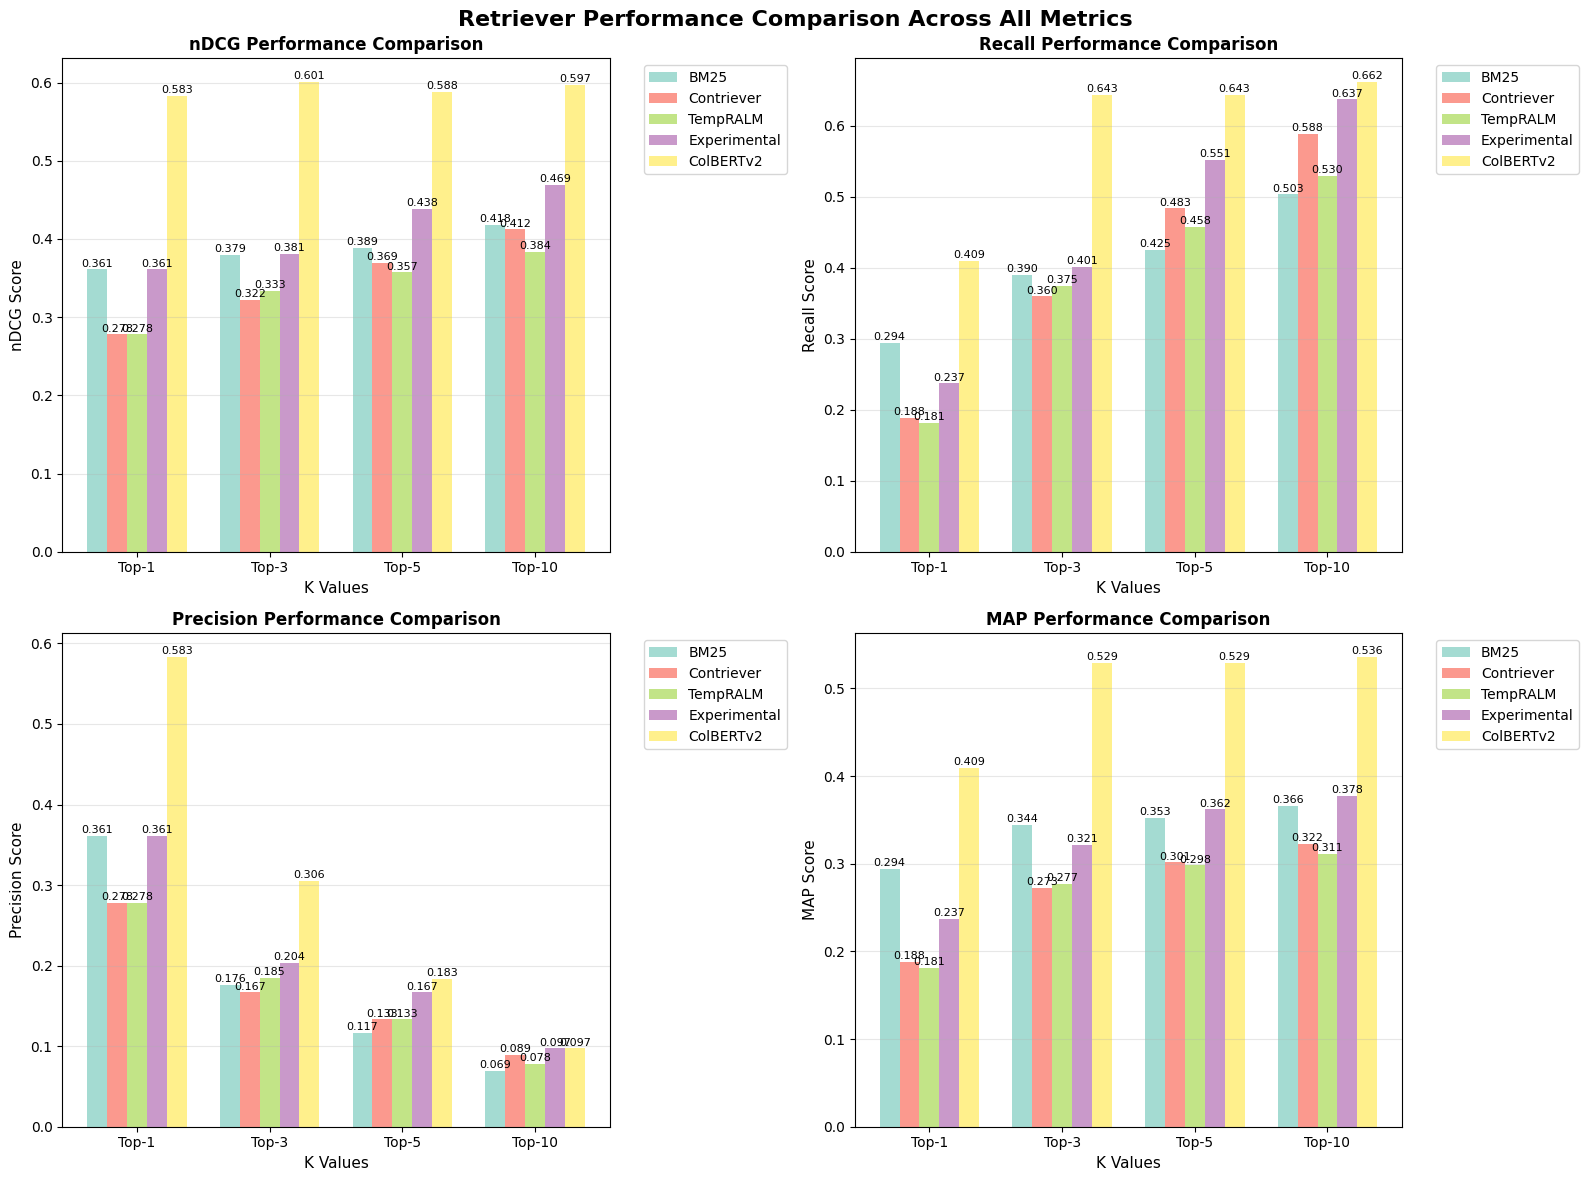


DETAILED PERFORMANCE COMPARISON

nDCG Performance:
------------------------------------------------------------
Retriever            Top-1      Top-3      Top-5      Top-10    
------------------------------------------------------------
BM25                0.3611    0.3795    0.3886    0.4180    
Contriever          0.2778    0.3215    0.3695    0.4121    
TempRALM            0.2778    0.3332    0.3572    0.3837    
Experimental        0.3611    0.3808    0.4381    0.4694    
ColBERTv2           0.5833    0.6009    0.5879    0.5969    

Recall Performance:
------------------------------------------------------------
Retriever            Top-1      Top-3      Top-5      Top-10    
------------------------------------------------------------
BM25                0.2940    0.3898    0.4245    0.5032    
Contriever          0.1884    0.3597    0.4833    0.5884    
TempRALM            0.1815    0.3745    0.4579    0.5296    
Experimental        0.2370    0.4014    0.5514    0.6370    
ColB

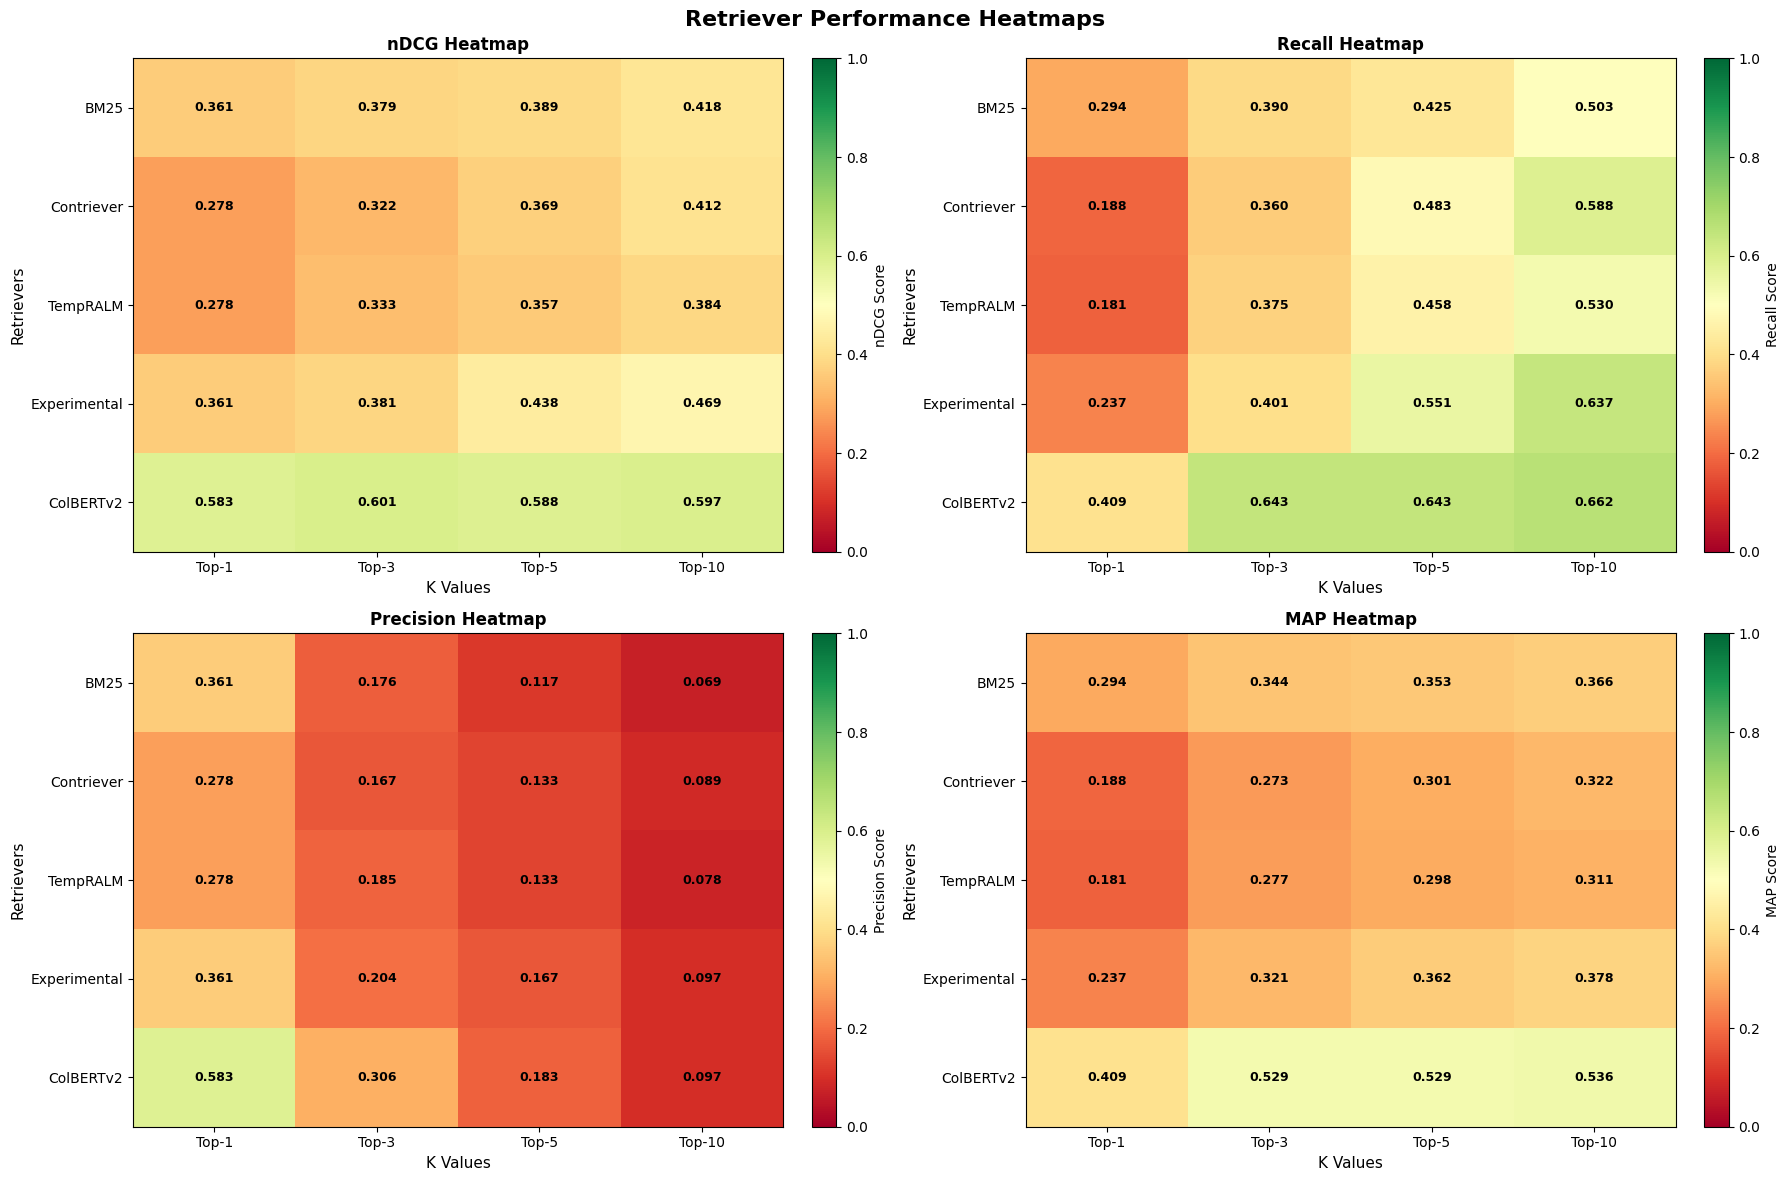


RANKING ANALYSIS - BEST RETRIEVER FOR EACH METRIC@K

nDCG Rankings:
--------------------------------------------------
nDCG@1:
  1. ColBERTv2            0.5833
  2. BM25                 0.3611
  3. Experimental         0.3611
  4. Contriever           0.2778
  5. TempRALM             0.2778
nDCG@3:
  1. ColBERTv2            0.6009
  2. Experimental         0.3808
  3. BM25                 0.3795
  4. TempRALM             0.3332
  5. Contriever           0.3215
nDCG@5:
  1. ColBERTv2            0.5879
  2. Experimental         0.4381
  3. BM25                 0.3886
  4. Contriever           0.3695
  5. TempRALM             0.3572
nDCG@10:
  1. ColBERTv2            0.5969
  2. Experimental         0.4694
  3. BM25                 0.4180
  4. Contriever           0.4121
  5. TempRALM             0.3837

Recall Rankings:
--------------------------------------------------
Recall@1:
  1. ColBERTv2            0.4093
  2. BM25                 0.2940
  3. Experimental         0.2370
  4. Cont

In [21]:
# Collect results for each retriever type
retriever_results = {}
k_values = [1, 3, 5, 10]

print("Evaluating all retrievers...")
for retriever_name, (retriever, score_function) in retrievers.items():
    print(f"\nEvaluating {retriever_name} retriever:")
    results = evaluate_langchain_retriever(
        retriever=retriever, 
        score_function=score_function,
        queries_csv="combined_queries.csv", 
        qrels_csv="combined_qrels.csv", 
        k_values=k_values,
        verbose=True  # Set to False to reduce output
    )
    retriever_results[retriever_name] = results
    print(f"Results for {retriever_name}: {results}")

# manually add ColBERTv2 results for comparison
retriever_results["ColBERTv2"] = {'nDCG': {'NDCG@1': 0.58333, 'NDCG@3': 0.60088, 'NDCG@5': 0.58789, 'NDCG@10': 0.59687}, 'Recall': {'Recall@1': 0.40926, 'Recall@3': 0.64306, 'Recall@5': 0.64306, 'Recall@10': 0.66157}, 'Precision': {'P@1': 0.58333, 'P@3': 0.30556, 'P@5': 0.18333, 'P@10': 0.09722}, 'MAP': {'MAP@1': 0.40926, 'MAP@3': 0.52886, 'MAP@5': 0.52886, 'MAP@10': 0.53613}}
print("\nData collection complete for all retrievers!")
plot_retriever_results(retriever_results, k_values)
plot_retriever_heatmaps(retriever_results, k_values)
save_retriever_results(retriever_results)


### Helper Functions for plotting etc.

In [ ]:
# Create comprehensive visualizations comparing all retrievers
import matplotlib.pyplot as plt
import numpy as np

# Define correct key mappings for each metric
def get_metric_key(metric, k):
    if metric == 'nDCG':
        return f'NDCG@{k}'
    elif metric == 'Precision':
        return f'P@{k}'
    else:  # Recall and MAP
        return f'{metric}@{k}'


metrics = ['nDCG', 'Recall', 'Precision', 'MAP']
k_values = [1, 3, 5, 10]

def plot_retriever_results(retriever_results, k_values=[1, 3, 5, 10], metrics=['nDCG', 'Recall', 'Precision', 'MAP']):

    # Set up the plotting parameters
    retriever_names = list(retriever_results.keys())

    colors = plt.cm.Set3(np.linspace(0, 1, len(retriever_names)))

    # Create subplots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Retriever Performance Comparison Across All Metrics', fontsize=16, fontweight='bold')

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # Prepare data for grouped bar chart
        x = np.arange(len(k_values))  # the label locations
        width = 0.15  # the width of the bars
        
        for i, retriever_name in enumerate(retriever_names):
            values = []
            for k in k_values:
                key = get_metric_key(metric, k)
                values.append(retriever_results[retriever_name][metric][key])
            
            # Create bars with offset
            offset = (i - len(retriever_names)/2) * width + width/2
            bars = ax.bar(x + offset, values, width, label=retriever_name, 
                        color=colors[i], alpha=0.8)
            
            # Add value labels on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{value:.3f}', ha='center', va='bottom', fontsize=8, rotation=0)
        
        ax.set_xlabel('K Values', fontsize=11)
        ax.set_ylabel(f'{metric} Score', fontsize=11)
        ax.set_title(f'{metric} Performance Comparison', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([f'Top-{k}' for k in k_values])
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print("\n" + "="*100)
    print("DETAILED PERFORMANCE COMPARISON")
    print("="*100)

    # Create a detailed comparison table
    for metric in metrics:
        print(f"\n{metric} Performance:")
        print("-" * 60)
        print(f"{'Retriever':<20} {'Top-1':<10} {'Top-3':<10} {'Top-5':<10} {'Top-10':<10}")
        print("-" * 60)
        
        for retriever_name in retriever_names:
            row = f"{retriever_name:<20}"
            for k in k_values:
                key = get_metric_key(metric, k)
                value = retriever_results[retriever_name][metric][key]
                row += f"{value:<10.4f}"
            print(row)

def save_retriever_results(retriever_results, file_path="retriever_results.csv"):
    import pandas as pd

    # Flatten retriever_results for Excel export
    rows = []
    for retriever, metrics in retriever_results.items():
        for metric, values in metrics.items():
            for k, score in values.items():
                rows.append({
                    "Retriever": retriever,
                    "Metric": metric,
                    "K": k,
                    "Score": score
                })

    df = pd.DataFrame(rows)
    df.to_csv(file_path, index=False)
    print("Results saved to retriever_results.xlsx")



Results saved to retriever_results.xlsx


In [20]:
# Create heatmap visualization for retriever comparison

def plot_retriever_heatmaps(retriever_results, k_values=[1, 3, 5, 10], metrics=['nDCG', 'Recall', 'Precision', 'MAP']):
    # Set up the plotting parameters
    retriever_names = list(retriever_results.keys())
    
    # Create subplots for each metric

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Retriever Performance Heatmaps', fontsize=16, fontweight='bold')

    for idx, metric in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # Prepare data matrix: rows = retrievers, columns = k values
        data_matrix = []
        for retriever_name in retriever_names:
            row = []
            for k in k_values:
                key = get_metric_key(metric, k)
                row.append(retriever_results[retriever_name][metric][key])
            data_matrix.append(row)
        
        # Create heatmap
        im = ax.imshow(data_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        
        # Set ticks and labels
        ax.set_xticks(range(len(k_values)))
        ax.set_xticklabels([f'Top-{k}' for k in k_values])
        ax.set_yticks(range(len(retriever_names)))
        ax.set_yticklabels(retriever_names)
        
        ax.set_xlabel('K Values', fontsize=11)
        ax.set_ylabel('Retrievers', fontsize=11)
        ax.set_title(f'{metric} Heatmap', fontsize=12, fontweight='bold')
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label(f'{metric} Score', fontsize=10)
        
        # Add text annotations
        for i in range(len(retriever_names)):
            for j in range(len(k_values)):
                text = ax.text(j, i, f'{data_matrix[i][j]:.3f}',
                            ha="center", va="center", 
                            color="black" if data_matrix[i][j] < 0.5 else "black", #white
                            fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Ranking analysis
    print("\n" + "="*100)
    print("RANKING ANALYSIS - BEST RETRIEVER FOR EACH METRIC@K")
    print("="*100)

    for metric in metrics:
        print(f"\n{metric} Rankings:")
        print("-" * 50)
        
        for k in k_values:
            key = get_metric_key(metric, k)
            
            # Get scores for all retrievers for this metric@k
            scores = [(retriever_name, retriever_results[retriever_name][metric][key]) 
                    for retriever_name in retriever_names]
            
            # Sort by score (descending)
            scores.sort(key=lambda x: x[1], reverse=True)
            
            print(f"{metric}@{k}:")
            for rank, (retriever_name, score) in enumerate(scores, 1):
                print(f"  {rank}. {retriever_name:<20} {score:.4f}")

    # Overall performance summary
    print("\n" + "="*100)
    print("OVERALL PERFORMANCE SUMMARY")
    print("="*100)

    overall_scores = {}
    for retriever_name in retriever_names:
        total_score = 0
        count = 0
        for metric in metrics:
            for k in k_values:
                key = get_metric_key(metric, k)
                total_score += retriever_results[retriever_name][metric][key]
                count += 1

        # Avoid division by zero
        overall_scores[retriever_name] = total_score / count if count > 0 else 0

    # Sort by overall performance
    sorted_overall = sorted(overall_scores.items(), key=lambda x: x[1], reverse=True)

    print("\nOverall Performance Ranking (average across all metrics@k):")
    print("-" * 60)
    for rank, (retriever_name, avg_score) in enumerate(sorted_overall, 1):
        print(f"{rank}. {retriever_name:<20} Average Score: {avg_score:.4f}")


### Grid search to determine best decay_rate and alpha combination for example retriever

In [ ]:
# Grid search for optimal decay_rate and alpha combination
import itertools

print("=== GRID SEARCH FOR OPTIMAL DECAY_RATE AND ALPHA ===")

# Define parameter ranges
decay_rates = [0.001, 0.005, 0.01, 0.02, 0.05]  # 5 values
alphas = [0.3, 0.5, 0.7, 0.8, 0.9, 1.0]  # 6 values
# Total combinations: 5 * 6 = 30

grid_results = {}
best_score = 0
best_params = None

print(f"Testing {len(decay_rates)} decay_rates × {len(alphas)} alphas = {len(decay_rates) * len(alphas)} combinations")

for decay_rate, alpha in itertools.product(decay_rates, alphas):
    print(f"Testing decay_rate={decay_rate:.3f}, alpha={alpha:.1f}...", end=" ")
    
    try:
        retriever = SemanticRecencyRetriever(
            vectorstore=db,
            decay_rate=decay_rate,
            alpha=alpha,
            search_kwargs={"k": 10, "max_k": 1000},  # Reduced for speed
        )
        
        results = evaluate_langchain_retriever(
            retriever=retriever,
            queries_csv="combined_queries.csv",
            qrels_csv="combined_qrels.csv", 
            k_values=[5],  # Focus on nDCG@5
            verbose=False
        )
        
        # Use nDCG@5 as primary metric
        ndcg5 = results['nDCG']['NDCG@5']
        grid_results[(decay_rate, alpha)] = {
            'ndcg5': ndcg5,
            'recall5': results['Recall']['Recall@5'],
            'precision5': results['Precision']['P@5'],
            'map5': results['MAP']['MAP@5']
        }
        
        if ndcg5 > best_score:
            best_score = ndcg5
            best_params = (decay_rate, alpha)
            
        print(f"nDCG@5={ndcg5:.4f}")
        
    except Exception as e:
        print(f"ERROR: {e}")
        grid_results[(decay_rate, alpha)] = {'ndcg5': 0, 'recall5': 0, 'precision5': 0, 'map5': 0}

print(f"\n{'='*60}")
print("GRID SEARCH RESULTS")
print(f"{'='*60}")
print(f"Best parameters: decay_rate={best_params[0]:.3f}, alpha={best_params[1]:.1f}")
print(f"Best nDCG@5: {best_score:.4f}")

# Show top 5 combinations
sorted_results = sorted(grid_results.items(), key=lambda x: x[1]['ndcg5'], reverse=True)
print(f"\nTop 5 parameter combinations:")
print(f"{'Rank':<4} {'Decay Rate':<12} {'Alpha':<8} {'nDCG@5':<10} {'Recall@5':<10} {'Precision@5':<12} {'MAP@5':<10}")
print("-" * 75)

for i, ((decay_rate, alpha), metrics) in enumerate(sorted_results[:5], 1):
    print(f"{i:<4} {decay_rate:<12.3f} {alpha:<8.1f} {metrics['ndcg5']:<10.4f} {metrics['recall5']:<10.4f} {metrics['precision5']:<12.4f} {metrics['map5']:<10.4f}")

print(f"\n{'='*60}")

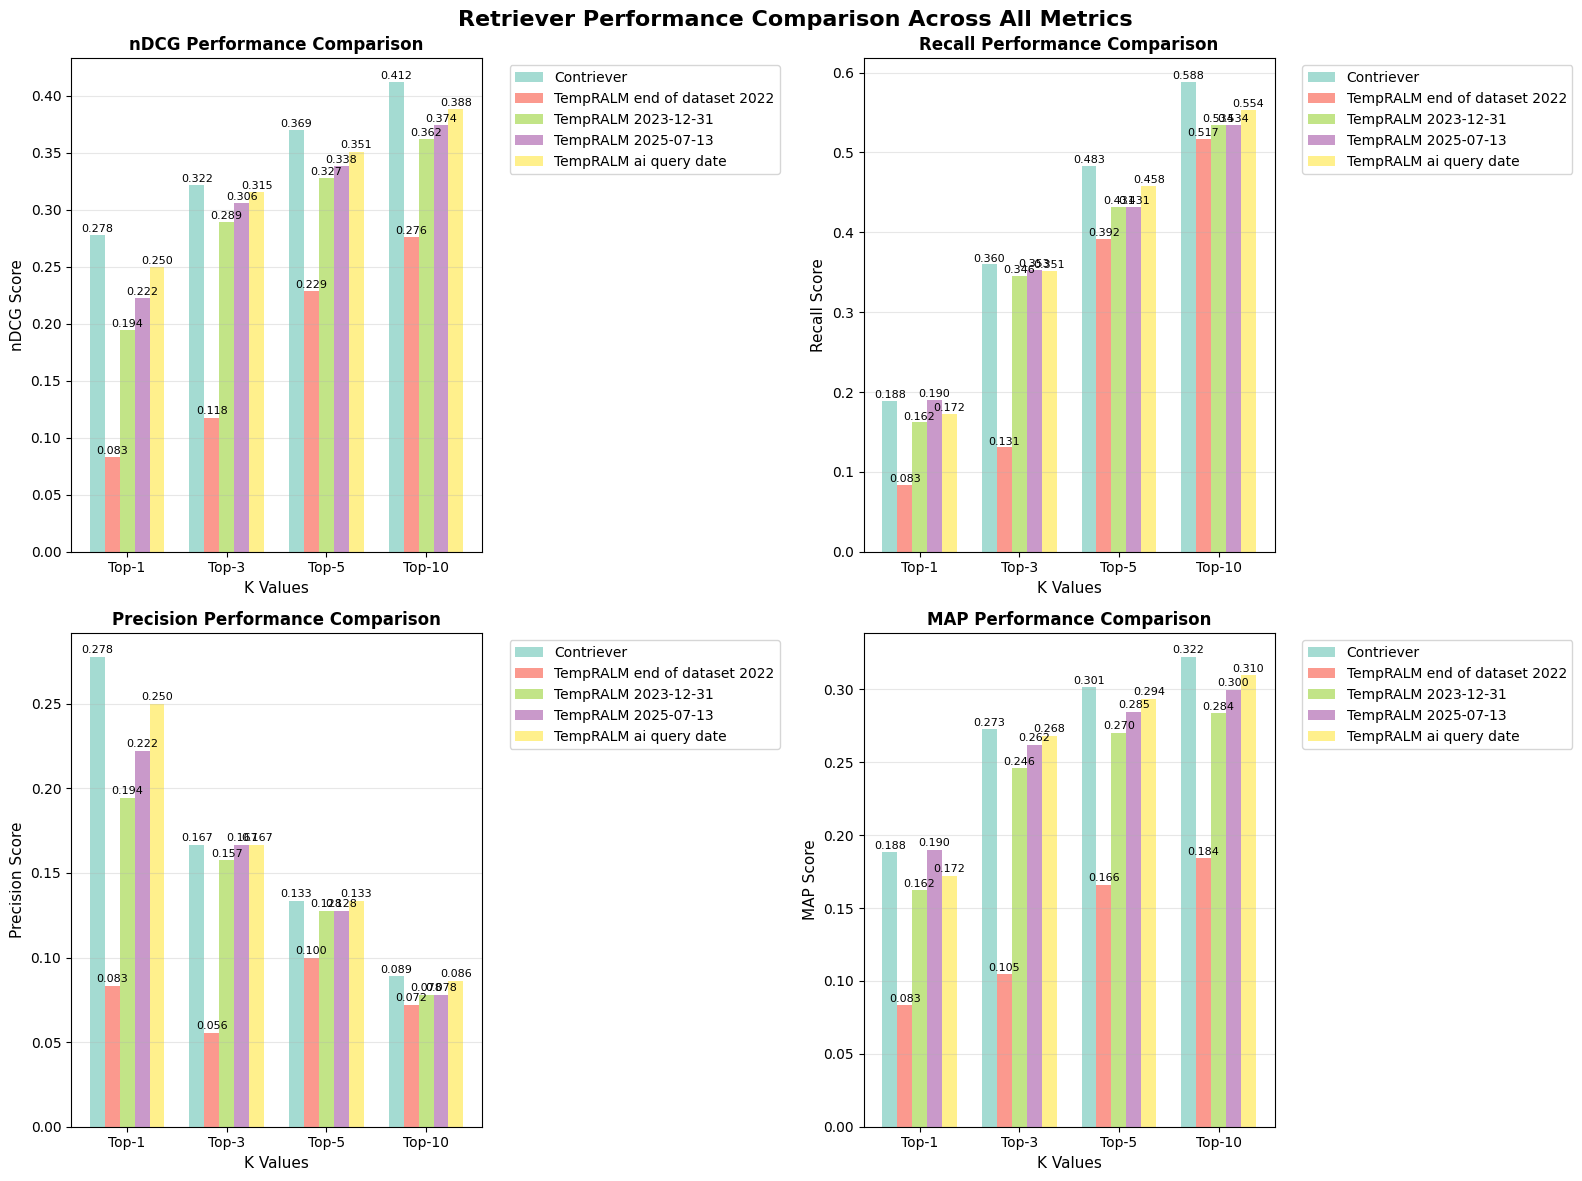


DETAILED PERFORMANCE COMPARISON

nDCG Performance:
------------------------------------------------------------
Retriever            Top-1      Top-3      Top-5      Top-10    
------------------------------------------------------------
Contriever          0.2778    0.3215    0.3695    0.4121    
TempRALM end of dataset 20220.0833    0.1176    0.2288    0.2760    
TempRALM 2023-12-31 0.1944    0.2892    0.3274    0.3618    
TempRALM 2025-07-13 0.2222    0.3060    0.3384    0.3745    
TempRALM ai query date0.2500    0.3152    0.3509    0.3882    

Recall Performance:
------------------------------------------------------------
Retriever            Top-1      Top-3      Top-5      Top-10    
------------------------------------------------------------
Contriever          0.1884    0.3597    0.4833    0.5884    
TempRALM end of dataset 20220.0833    0.1306    0.3921    0.5167    
TempRALM 2023-12-31 0.1620    0.3458    0.4315    0.5343    
TempRALM 2025-07-13 0.1898    0.3528    0.4315 

In [22]:
# custom plotting to visualize different dates on TempRALM retriever
retriever_results = {}
retriever_results["Contriever"] = {'nDCG': {'NDCG@1': 0.27778, 'NDCG@3': 0.32154, 'NDCG@5': 0.36947, 'NDCG@10': 0.4121}, 'Recall': {'Recall@1': 0.18843, 'Recall@3': 0.35972, 'Recall@5': 0.48333, 'Recall@10': 0.58843}, 'Precision': {'P@1': 0.27778, 'P@3': 0.16667, 'P@5': 0.13333, 'P@10': 0.08889}, 'MAP': {'MAP@1': 0.18843, 'MAP@3': 0.27253, 'MAP@5': 0.30149, 'MAP@10': 0.32226}}
retriever_results["TempRALM end of dataset 2022"] = {'nDCG': {'NDCG@1': 0.08333, 'NDCG@3': 0.1176, 'NDCG@5': 0.22882, 'NDCG@10': 0.27602}, 'Recall': {'Recall@1': 0.08333, 'Recall@3': 0.13056, 'Recall@5': 0.39213, 'Recall@10': 0.51667}, 'Precision': {'P@1': 0.08333, 'P@3': 0.05556, 'P@5': 0.1, 'P@10': 0.07222}, 'MAP': {'MAP@1': 0.08333, 'MAP@3': 0.10463, 'MAP@5': 0.16586, 'MAP@10': 0.18416}}
retriever_results["TempRALM 2023-12-31"] = {'nDCG': {'NDCG@1': 0.19444, 'NDCG@3': 0.28924, 'NDCG@5': 0.32741, 'NDCG@10': 0.36181}, 'Recall': {'Recall@1': 0.16204, 'Recall@3': 0.34583, 'Recall@5': 0.43148, 'Recall@10': 0.53426}, 'Precision': {'P@1': 0.19444, 'P@3': 0.15741, 'P@5': 0.12778, 'P@10': 0.07778}, 'MAP': {'MAP@1': 0.16204, 'MAP@3': 0.24583, 'MAP@5': 0.27025, 'MAP@10': 0.28361}}
retriever_results["TempRALM 2025-07-13"] = {'nDCG': {'NDCG@1': 0.22222, 'NDCG@3': 0.30601, 'NDCG@5': 0.33841, 'NDCG@10': 0.37447}, 'Recall': {'Recall@1': 0.18981, 'Recall@3': 0.35278, 'Recall@5': 0.43148, 'Recall@10': 0.53426}, 'Precision': {'P@1': 0.22222, 'P@3': 0.16667, 'P@5': 0.12778, 'P@10': 0.07778}, 'MAP': {'MAP@1': 0.18981, 'MAP@3': 0.26204, 'MAP@5': 0.28472, 'MAP@10': 0.29975}}
retriever_results["TempRALM ai query date"] = {'nDCG': {'NDCG@1': 0.25, 'NDCG@3': 0.31525, 'NDCG@5': 0.35093, 'NDCG@10': 0.38816}, 'Recall': {'Recall@1': 0.17222, 'Recall@3': 0.35139, 'Recall@5': 0.45787, 'Recall@10': 0.5537}, 'Precision': {'P@1': 0.25, 'P@3': 0.16667, 'P@5': 0.13333, 'P@10': 0.08611}, 'MAP': {'MAP@1': 0.17222, 'MAP@3': 0.26806, 'MAP@5': 0.29352, 'MAP@10': 0.30955}}

plot_retriever_results(retriever_results, k_values)

In [ ]:
# check for a good value to over retrieve for TempRALM
# -> to give it the benefit of the doubt, since the paper does not specify the amount of over-retrieval
# -> around 250 is a good value but the best is not to use it at all 
# -> smallest k as possible for tempralm to have as little effect as possible


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Let's collect the results systematically for visualization
over_retrieval_results = {}

for i in range(10, 1001, 50):
     max_k = i
     print(f"Testing max_k={max_k:.2f}")

     retriever = TempRALMRetriever(
          vectorstore   = db,
          alpha = 1, # irrelevant
          search_kwargs = {"k": k, "max_k": max_k},
     )

     results = evaluate_langchain_retriever(
          retriever=retriever, 
          queries_csv="combined_queries.csv", 
          qrels_csv="combined_qrels.csv", 
          k_values=[1, 3, 5, 10],
          verbose=False,
     )

     over_retrieval_results[max_k] = results

print("Data collection complete!")


In [ ]:
# Create visualization of the 
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Performance vs Over Retrieval', fontsize=16, fontweight='bold')

# Prepare data for plotting
max_ks = sorted(over_retrieval_results.keys())
metrics = ['nDCG', 'Recall', 'Precision', 'MAP']
k_values = [1, 3, 5, 10]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Define correct key mappings for each metric
def get_metric_key(metric, k):
    if metric == 'nDCG':
        return f'NDCG@{k}'
    elif metric == 'Precision':
        return f'P@{k}'
    else:  # Recall and MAP
        return f'{metric}@{k}'

# Plot each metric
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    for k_idx, k in enumerate(k_values):
        values = []
        for max_k in max_ks:
            key = get_metric_key(metric, k)
            values.append(over_retrieval_results[max_k][metric][key])
        
        ax.plot(max_ks, values, marker='o', linewidth=2, markersize=4, 
                color=colors[k_idx], label=f'Top-{k}', alpha=0.8)
    
    ax.set_xlabel('max_k', fontsize=11)
    ax.set_ylabel(f'{metric} Score', fontsize=11)
    ax.set_title(f'{metric} Performance vs max_k', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlim(0, max_ks[-1])

plt.tight_layout()
plt.show()

# Create a summary table showing best alpha for each metric and k
print("\n" + "="*80)
print("BEST max_k")
print("="*80)

best_ks = {}
for metric in metrics:
    best_ks[metric] = {}
    for k in k_values:
        key = get_metric_key(metric, k)
        
        best_k = max(max_ks, key=lambda a: over_retrieval_results[a][metric][key])
        best_value = over_retrieval_results[best_k][metric][key]
        best_ks[metric][k] = (best_k, best_value)
        
        print(f"{metric}@{k:2d}: Best max_k = {best_k:.2f} (score = {best_value:.4f})")

print("\n" + "="*80)

In [ ]:
# Beispielrechnung nDCG für Präsentation 
import math

user1 = [1,0,1]
user2 = [0,1,1]
user3 = [0,0,0]

def calcNdcg(user):
    idcg = getIdcg(len(user))
    dcg = getDcg(user)
    ndcg = dcg / idcg
    print(ndcg)
    return ndcg

def getIdcg(n):
    idcg = 0
    for i in range(1, n + 1):
        idcg = idcg + 1 / math.log2(i + 1)
    return idcg
    
def getDcg(user):
    dcg = 0
    for i in range(1, len(user) + 1):
        dcg = dcg + user[i - 1] / math.log2(i + 1)
    return dcg

n1 = calcNdcg(user1)
n2 = calcNdcg(user2)
n3 = calcNdcg(user3)
print("Average: " + str((n1 + n2 + n3) / 3))